# Epoxy-resin polymer thermoset material with multiple output QoIs

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the epoxy resin application. The notebook is similar to `epoxy.ipynb`, except that here we train a DAS surrogate on vector-valued outputs, i.e. on multiple QoIs simultaneously. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON file below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

# number of samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs. We used `E11`, the 11 component of the elasticity tensor (equal to the Young's modulus `E` in this isotropic case), and the Poisson ratio.

In [7]:
# Output QoI
QoIs = ['E11', 'bulk', 'shear2', 'poisson']

output = []

for qoi in QoIs:
    output.append(pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (qoi,)).values)
    
output = np.array(output)

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, :, 0].reshape([-1, len(QoIs)])
else:
    samples = np.mean(output, axis=2).T

### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

###  Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 4
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=True)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
#         W_1 = das_surrogate.neural_net.layers[1].W
#         results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=True)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.4`.

In [15]:
train_das(failure_criterion=0.4)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 4
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 277 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 223.59it/s]


 loss = 1.8144
Relative training error = 34.5839 %
Relative test error = 28.9756 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.80it/s]

 loss = 1.1504


Relative training error = 31.9935 %
Relative test error = 26.4470 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.70it/s]


 loss = 0.9148
Relative training error = 27.8238 %
Relative test error = 24.3907 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.92it/s]


 loss = 0.4498
Relative training error = 23.7452 %
Relative test error = 20.5141 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.54it/s]

 loss = 0.4566


Relative training error = 20.8540 %
Relative test error = 18.5025 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.93it/s]


 loss = 0.2673
Relative training error = 18.8600 %
Relative test error = 17.0604 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.38it/s]

 loss = 0.2394


Relative training error = 17.5974 %
Relative test error = 14.6872 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.89it/s]

 loss = 0.1944


Relative training error = 16.7272 %
Relative test error = 12.9702 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.59it/s]

 loss = 0.1701


Relative training error = 15.9096 %
Relative test error = 12.1269 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.10it/s]

 loss = 0.2114


Relative training error = 15.1883 %
Relative test error = 11.9333 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.67it/s]


Relative training error = 14.5625 %
Relative test error = 11.0592 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.02it/s]

 loss = 0.1512


Relative training error = 13.9952 %
Relative test error = 10.9958 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.24it/s]


Relative training error = 13.6484 %
Relative test error = 10.0537 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.87it/s]


Relative training error = 13.1755 %
Relative test error = 10.6843 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.37it/s]


Relative training error = 12.7525 %
Relative test error = 10.2692 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.89it/s]

 loss = 0.1669


Relative training error = 12.3823 %
Relative test error = 10.3878 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.68it/s]

 loss = 0.1981


Relative training error = 12.0339 %
Relative test error = 10.6943 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.31it/s]

 loss = 0.0923


Relative training error = 11.6165 %
Relative test error = 10.1896 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.80it/s]

 loss = 0.1805


Relative training error = 11.2999 %
Relative test error = 10.1145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 796.63it/s]

 loss = 0.1148


Relative training error = 11.1343 %
Relative test error = 10.0598 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.83it/s]

 loss = 0.1445


Relative training error = 10.9956 %
Relative test error = 9.9455 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 774.93it/s]

 loss = 0.1268


Relative training error = 10.7779 %
Relative test error = 9.9496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.81it/s]

 loss = 0.1548


Relative training error = 10.6114 %
Relative test error = 10.0297 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.95it/s]

 loss = 0.1416


Relative training error = 10.4456 %
Relative test error = 9.7476 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.06it/s]

 loss = 0.0897


Relative training error = 10.3265 %
Relative test error = 9.9024 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.18it/s]

 loss = 0.0982


Relative training error = 10.1103 %
Relative test error = 9.8036 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.60it/s]

 loss = 0.1556


Relative training error = 9.9009 %
Relative test error = 9.9236 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.10it/s]

 loss = 0.1530


Relative training error = 9.7491 %
Relative test error = 9.5736 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.49it/s]


 loss = 1.1258
Relative training error = 33.2379 %
Relative test error = 29.4232 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.72it/s]


Relative training error = 29.7724 %
Relative test error = 28.7844 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.04it/s]

 loss = 0.9499


Relative training error = 26.0019 %
Relative test error = 24.5687 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.27it/s]


 loss = 0.4659
Relative training error = 23.2665 %
Relative test error = 21.7116 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.19it/s]


 loss = 0.3915
Relative training error = 21.0732 %
Relative test error = 19.6926 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 775.95it/s]

 loss = 0.3486


Relative training error = 19.3598 %
Relative test error = 18.2212 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.94it/s]


 loss = 0.2034
Relative training error = 18.0322 %
Relative test error = 17.2652 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.93it/s]

 loss = 0.2248


Relative training error = 16.8856 %
Relative test error = 15.8589 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.09it/s]

 loss = 0.3615


Relative training error = 15.8933 %
Relative test error = 15.0614 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.60it/s]

 loss = 0.1381


Relative training error = 15.0712 %
Relative test error = 14.0511 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.96it/s]

 loss = 0.2329


Relative training error = 14.3780 %
Relative test error = 12.9300 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.74it/s]

 loss = 0.1889


Relative training error = 13.9009 %
Relative test error = 12.4120 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.45it/s]


Relative training error = 13.4605 %
Relative test error = 11.8735 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.25it/s]

 loss = 0.1231


Relative training error = 13.0940 %
Relative test error = 11.0409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.64it/s]

 loss = 0.1042


Relative training error = 12.8619 %
Relative test error = 10.9998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.88it/s]

 loss = 0.1898


Relative training error = 12.5658 %
Relative test error = 11.2230 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.47it/s]

 loss = 0.1827


Relative training error = 12.2196 %
Relative test error = 11.1553 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.82it/s]

 loss = 0.0924


Relative training error = 12.0666 %
Relative test error = 10.6836 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.92it/s]


 loss = 2.1847
Relative training error = 32.9306 %
Relative test error = 27.7326 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6395


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.11it/s]


Relative training error = 29.7457 %
Relative test error = 26.3782 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.38it/s]

 loss = 0.6515


Relative training error = 25.4827 %
Relative test error = 22.5870 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.75it/s]


 loss = 0.5434
Relative training error = 22.4948 %
Relative test error = 19.1693 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.62it/s]

 loss = 0.6218


Relative training error = 20.2748 %
Relative test error = 16.4245 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.22it/s]

 loss = 0.1824


Relative training error = 18.7994 %
Relative test error = 14.6002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.30it/s]

 loss = 0.2513


Relative training error = 17.1943 %
Relative test error = 13.1840 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.30it/s]

 loss = 0.3075


Relative training error = 16.0036 %
Relative test error = 12.2775 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.15it/s]

 loss = 0.3257


Relative training error = 14.9169 %
Relative test error = 11.3455 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.40it/s]

 loss = 0.2514


Relative training error = 14.2586 %
Relative test error = 10.6339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.78it/s]

 loss = 0.1239


Relative training error = 13.7681 %
Relative test error = 10.1580 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.09it/s]

 loss = 0.1609


Relative training error = 13.3120 %
Relative test error = 9.4592 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.95it/s]

 loss = 0.0846


Relative training error = 12.9202 %
Relative test error = 9.3577 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.25it/s]

 loss = 0.1759


Relative training error = 12.6445 %
Relative test error = 9.5473 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 770.65it/s]

 loss = 0.0959


Relative training error = 12.5422 %
Relative test error = 9.4049 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.74it/s]

 loss = 0.1555


Relative training error = 12.3432 %
Relative test error = 9.5744 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.00it/s]

 loss = 0.2464


Relative training error = 12.1591 %
Relative test error = 9.9271 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.01it/s]

 loss = 0.2110


Relative training error = 11.9250 %
Relative test error = 9.9436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.82it/s]

 loss = 0.2078


Relative training error = 11.6842 %
Relative test error = 9.7094 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.80it/s]


 loss = 1.1762
Relative training error = 35.4725 %
Relative test error = 30.5157 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.06it/s]

 loss = 0.9681


Relative training error = 34.8417 %
Relative test error = 29.0232 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.04it/s]

 loss = 0.6077


Relative training error = 33.4835 %
Relative test error = 27.7274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.25it/s]


 loss = 1.0009
Relative training error = 30.4147 %
Relative test error = 26.1227 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.75it/s]

 loss = 0.6198


Relative training error = 27.2570 %
Relative test error = 22.7564 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.86it/s]

 loss = 1.0476


Relative training error = 24.5123 %
Relative test error = 20.4570 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.59it/s]

 loss = 0.3405


Relative training error = 22.5130 %
Relative test error = 18.4287 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.21it/s]

 loss = 0.7553


Relative training error = 20.9345 %
Relative test error = 17.3226 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.74it/s]

 loss = 0.6457


Relative training error = 19.1345 %
Relative test error = 16.2615 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.40it/s]

 loss = 0.3575


Relative training error = 17.7220 %
Relative test error = 15.4849 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.54it/s]

 loss = 0.1636


Relative training error = 16.4647 %
Relative test error = 13.6812 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.32it/s]

 loss = 0.1539


Relative training error = 15.4973 %
Relative test error = 13.2817 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.70it/s]


 loss = 0.2222
Relative training error = 14.7035 %
Relative test error = 12.5926 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.07it/s]

 loss = 0.3162


Relative training error = 14.0636 %
Relative test error = 12.1844 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.63it/s]

 loss = 0.1065


Relative training error = 13.4982 %
Relative test error = 11.9830 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.68it/s]


 loss = 0.1023
Relative training error = 12.9701 %
Relative test error = 11.6913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.57it/s]

 loss = 0.1090


Relative training error = 12.4839 %
Relative test error = 11.2193 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.31it/s]

 loss = 0.1841


Relative training error = 12.1344 %
Relative test error = 10.9745 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.11it/s]

 loss = 0.1943


Relative training error = 11.8764 %
Relative test error = 10.4739 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.26it/s]

 loss = 0.1158


Relative training error = 11.5727 %
Relative test error = 10.0731 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.68it/s]

 loss = 0.2423


Relative training error = 11.3535 %
Relative test error = 9.8961 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.51it/s]

 loss = 0.0768


Relative training error = 11.1576 %
Relative test error = 9.9092 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.65it/s]

 loss = 0.0912


Relative training error = 11.0211 %
Relative test error = 10.0360 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 771.91it/s]


 loss = 0.1182
Relative training error = 10.8987 %
Relative test error = 9.7383 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.17it/s]

 loss = 0.1407


Relative training error = 10.8199 %
Relative test error = 9.7073 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.15it/s]

 loss = 0.1269


Relative training error = 10.5680 %
Relative test error = 9.5814 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.04it/s]

 loss = 0.1012


Relative training error = 10.4214 %
Relative test error = 9.6446 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.28it/s]

 loss = 0.1659


Relative training error = 10.3789 %
Relative test error = 9.4605 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.38it/s]


 loss = 0.1317
Relative training error = 10.3398 %
Relative test error = 9.5894 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.44it/s]

 loss = 0.0969


Relative training error = 10.1320 %
Relative test error = 9.5543 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.76it/s]

 loss = 0.0985


Relative training error = 10.1021 %
Relative test error = 9.4270 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.35it/s]


Relative training error = 9.9765 %
Relative test error = 9.4052 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.60it/s]

 loss = 0.0966


Relative training error = 9.9915 %
Relative test error = 9.4791 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.96it/s]

 loss = 0.1286


Relative training error = 9.9797 %
Relative test error = 9.5544 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.92it/s]

 loss = 0.1442


Relative training error = 9.9583 %
Relative test error = 9.5165 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.53it/s]


 loss = 1.9362
Relative training error = 34.1023 %
Relative test error = 29.7134 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.42it/s]

 loss = 1.4382


Relative training error = 31.0995 %
Relative test error = 29.1631 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.25it/s]

 loss = 0.8002


Relative training error = 27.0299 %
Relative test error = 25.9693 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 784.23it/s]


 loss = 0.5689
Relative training error = 23.0871 %
Relative test error = 22.7467 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.97it/s]

 loss = 0.5442


Relative training error = 19.9590 %
Relative test error = 19.4664 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.38it/s]


Relative training error = 17.5318 %
Relative test error = 15.9543 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.72it/s]

 loss = 0.2460


Relative training error = 15.6652 %
Relative test error = 14.1980 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.48it/s]


 loss = 0.4322
Relative training error = 14.2891 %
Relative test error = 12.9309 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.92it/s]


 loss = 0.1396
Relative training error = 13.5098 %
Relative test error = 11.9466 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.27it/s]

 loss = 0.3301


Relative training error = 12.7730 %
Relative test error = 11.2610 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.80it/s]

 loss = 0.1298


Relative training error = 12.0858 %
Relative test error = 11.0697 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.49it/s]

 loss = 0.1420


Relative training error = 11.7266 %
Relative test error = 10.6072 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.34it/s]

 loss = 0.1026


Relative training error = 11.5296 %
Relative test error = 10.0002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.63it/s]

 loss = 0.2347


Relative training error = 11.0904 %
Relative test error = 9.8124 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.41it/s]


 loss = 0.1213
Relative training error = 10.9809 %
Relative test error = 9.7243 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.78it/s]

 loss = 0.1377


Relative training error = 10.7994 %
Relative test error = 9.5287 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.49it/s]


Relative training error = 10.6422 %
Relative test error = 9.7834 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.54it/s]


Relative training error = 10.5353 %
Relative test error = 9.7253 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.52it/s]

 loss = 0.1326


Relative training error = 10.2896 %
Relative test error = 9.9509 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.23it/s]


 loss = 0.1205
Relative training error = 10.2257 %
Relative test error = 9.7882 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.7093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.53it/s]


Relative training error = 35.3118 %
Relative test error = 29.3586 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.20it/s]


Relative training error = 34.8006 %
Relative test error = 29.3720 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.47it/s]

 loss = 0.7568


Relative training error = 33.8175 %
Relative test error = 27.9441 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.86it/s]

 loss = 1.9664


Relative training error = 30.7038 %
Relative test error = 26.8989 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.35it/s]

 loss = 0.9384


Relative training error = 25.3741 %
Relative test error = 22.0123 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.53it/s]

 loss = 0.4291


Relative training error = 20.4094 %
Relative test error = 17.4152 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.22it/s]

 loss = 0.2090


Relative training error = 17.8675 %
Relative test error = 15.0098 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 776.44it/s]

 loss = 0.3506


Relative training error = 16.1267 %
Relative test error = 14.1373 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.06it/s]

 loss = 0.1971


Relative training error = 14.7712 %
Relative test error = 12.1575 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.19it/s]

 loss = 0.1509


Relative training error = 13.8587 %
Relative test error = 11.9903 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.51it/s]

 loss = 0.0683


Relative training error = 13.2700 %
Relative test error = 11.2558 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.75it/s]


 loss = 0.2057
Relative training error = 12.8078 %
Relative test error = 10.3314 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.05it/s]


 loss = 0.1429
Relative training error = 12.3862 %
Relative test error = 10.3015 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.85it/s]

 loss = 0.1955


Relative training error = 12.1509 %
Relative test error = 10.1491 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.24it/s]

 loss = 0.1629


Relative training error = 11.9981 %
Relative test error = 9.6666 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.84it/s]

 loss = 0.1563


Relative training error = 11.7502 %
Relative test error = 9.8698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.63it/s]


 loss = 0.1342
Relative training error = 11.4835 %
Relative test error = 9.6478 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.22it/s]

 loss = 0.1623


Relative training error = 11.2046 %
Relative test error = 9.7004 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.31it/s]


 loss = 0.1431
Relative training error = 11.0229 %
Relative test error = 9.5659 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.97it/s]


 loss = 0.1084
Relative training error = 10.8876 %
Relative test error = 9.3669 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1338


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.95it/s]


Relative training error = 10.7157 %
Relative test error = 10.1812 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.89it/s]

 loss = 0.2104


Relative training error = 10.4841 %
Relative test error = 9.7038 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.84it/s]

 loss = 0.1881


Relative training error = 10.3698 %
Relative test error = 9.9834 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.39it/s]

 loss = 0.1160


Relative training error = 10.2640 %
Relative test error = 10.0532 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.52it/s]

 loss = 0.0924


Relative training error = 10.2619 %
Relative test error = 10.1019 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.94it/s]

 loss = 0.0977


Relative training error = 10.1297 %
Relative test error = 9.6655 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.42it/s]


Relative training error = 33.0175 %
Relative test error = 27.4898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.98it/s]

 loss = 0.7562


Relative training error = 28.3115 %
Relative test error = 25.7987 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.49it/s]

 loss = 0.8859


Relative training error = 24.0326 %
Relative test error = 24.6950 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 803.90it/s]

 loss = 0.2876


Relative training error = 21.2119 %
Relative test error = 20.7539 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.76it/s]

 loss = 0.3318


Relative training error = 19.1721 %
Relative test error = 17.7279 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.60it/s]

 loss = 0.2485


Relative training error = 17.9949 %
Relative test error = 15.8510 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.50it/s]


 loss = 0.2459
Relative training error = 16.7941 %
Relative test error = 14.5607 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.32it/s]

 loss = 0.5406


Relative training error = 15.6099 %
Relative test error = 14.9727 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.78it/s]

 loss = 0.1752


Relative training error = 14.8386 %
Relative test error = 14.3101 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.68it/s]


 loss = 0.1294
Relative training error = 14.2620 %
Relative test error = 12.5086 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.03it/s]

 loss = 0.1011


Relative training error = 13.8493 %
Relative test error = 12.2057 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.88it/s]

 loss = 0.1616


Relative training error = 13.4694 %
Relative test error = 12.0522 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.79it/s]

 loss = 0.1420


Relative training error = 13.1685 %
Relative test error = 10.3388 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 605.54it/s]

 loss = 0.1613


Relative training error = 12.7050 %
Relative test error = 10.8568 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.80it/s]


Relative training error = 12.3500 %
Relative test error = 11.6080 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.90it/s]


Relative training error = 12.0792 %
Relative test error = 10.2364 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.26it/s]


Relative training error = 11.9308 %
Relative test error = 9.9978 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.49it/s]


Relative training error = 11.7275 %
Relative test error = 10.8743 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.33it/s]

 loss = 0.1652


Relative training error = 11.5282 %
Relative test error = 10.3377 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.06it/s]

 loss = 0.1973


Relative training error = 11.4963 %
Relative test error = 9.7091 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.66it/s]

 loss = 0.1075


Relative training error = 11.2206 %
Relative test error = 10.0640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 813.71it/s]

 loss = 0.0792


Relative training error = 11.0737 %
Relative test error = 10.2475 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.68it/s]


 loss = 0.0816
Relative training error = 11.0725 %
Relative test error = 11.0787 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.87it/s]

 loss = 0.1131


Relative training error = 10.7581 %
Relative test error = 11.0727 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.27it/s]


Relative training error = 35.2496 %
Relative test error = 30.8562 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.31it/s]

 loss = 0.6846


Relative training error = 33.0902 %
Relative test error = 29.6891 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.48it/s]

 loss = 0.6959


Relative training error = 30.2249 %
Relative test error = 27.5050 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.12it/s]

 loss = 0.7223


Relative training error = 26.7287 %
Relative test error = 27.0835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.08it/s]

 loss = 0.7519


Relative training error = 23.5877 %
Relative test error = 22.6329 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.65it/s]

 loss = 0.3532


Relative training error = 21.3405 %
Relative test error = 21.1065 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.80it/s]

 loss = 0.3549


Relative training error = 19.6092 %
Relative test error = 18.1030 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.70it/s]

 loss = 0.2277


Relative training error = 18.0949 %
Relative test error = 16.9976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.34it/s]

 loss = 0.5097


Relative training error = 16.7605 %
Relative test error = 15.9151 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.99it/s]

 loss = 0.1831


Relative training error = 15.6916 %
Relative test error = 15.6557 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.53it/s]


 loss = 0.1835
Relative training error = 14.7955 %
Relative test error = 14.1468 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.29it/s]

 loss = 0.2563


Relative training error = 14.0831 %
Relative test error = 12.5313 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.93it/s]


 loss = 0.1622
Relative training error = 13.5747 %
Relative test error = 11.2574 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.81it/s]


 loss = 0.4229
Relative training error = 13.1053 %
Relative test error = 10.8522 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.29it/s]

 loss = 0.1270


Relative training error = 12.7971 %
Relative test error = 10.4195 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.94it/s]


Relative training error = 12.4258 %
Relative test error = 10.2496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.30it/s]

 loss = 0.1169


Relative training error = 12.1882 %
Relative test error = 9.9741 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.64it/s]

 loss = 0.1270


Relative training error = 11.9201 %
Relative test error = 10.2326 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.61it/s]

 loss = 0.1081


Relative training error = 11.7439 %
Relative test error = 9.6527 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 806.62it/s]


 loss = 0.1076
Relative training error = 11.5927 %
Relative test error = 9.1487 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.78it/s]

 loss = 0.1235


Relative training error = 11.3572 %
Relative test error = 10.0135 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.49it/s]


 loss = 0.0900
Relative training error = 11.0895 %
Relative test error = 9.5429 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.32it/s]


 loss = 0.1420
Relative training error = 10.9500 %
Relative test error = 9.6788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.19it/s]


 loss = 0.1783
Relative training error = 10.7920 %
Relative test error = 10.0720 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.29it/s]

 loss = 0.0908


Relative training error = 10.5995 %
Relative test error = 9.7327 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.27it/s]

 loss = 0.1573


Relative training error = 10.5195 %
Relative test error = 9.8996 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.51it/s]

 loss = 0.1208


Relative training error = 10.4791 %
Relative test error = 9.6631 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.81it/s]

 loss = 0.2464


Relative training error = 10.3664 %
Relative test error = 9.7462 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.11it/s]

 loss = 0.0954


Relative training error = 10.2237 %
Relative test error = 9.6346 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.40it/s]

 loss = 0.1244


Relative training error = 10.0788 %
Relative test error = 9.5582 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.05it/s]

 loss = 0.0964


Relative training error = 10.0092 %
Relative test error = 9.5998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.08it/s]

 loss = 0.0906


Relative training error = 9.9447 %
Relative test error = 9.9680 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.48it/s]

 loss = 0.0581


Relative training error = 9.8783 %
Relative test error = 10.0686 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.70it/s]


 loss = 2.2688
Relative training error = 37.1241 %
Relative test error = 31.8894 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.94it/s]


Relative training error = 33.0979 %
Relative test error = 29.2867 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.93it/s]

 loss = 0.5941


Relative training error = 30.5282 %
Relative test error = 28.1502 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 771.74it/s]


 loss = 0.7122
Relative training error = 27.4500 %
Relative test error = 26.2166 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.94it/s]


 loss = 0.6671
Relative training error = 24.3607 %
Relative test error = 22.8512 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.50it/s]

 loss = 0.3751


Relative training error = 21.9219 %
Relative test error = 20.2757 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.96it/s]

 loss = 0.3717


Relative training error = 19.9273 %
Relative test error = 18.2169 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.19it/s]

 loss = 0.3785


Relative training error = 18.4203 %
Relative test error = 16.1123 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.13it/s]

 loss = 0.2249


Relative training error = 17.0965 %
Relative test error = 14.9233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.42it/s]


 loss = 0.2950
Relative training error = 16.0421 %
Relative test error = 14.3900 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.81it/s]

 loss = 0.1521


Relative training error = 15.2764 %
Relative test error = 13.1364 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.77it/s]


 loss = 0.3667
Relative training error = 14.7466 %
Relative test error = 12.3500 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 810.60it/s]

 loss = 0.2635


Relative training error = 14.2262 %
Relative test error = 11.7267 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.01it/s]


 loss = 0.2068
Relative training error = 13.7945 %
Relative test error = 11.4173 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.15it/s]

 loss = 0.2346


Relative training error = 13.3480 %
Relative test error = 11.2076 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.63it/s]

 loss = 0.2358


Relative training error = 13.0105 %
Relative test error = 10.9796 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.53it/s]

 loss = 0.2080


Relative training error = 12.7215 %
Relative test error = 10.7409 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.00it/s]


Relative training error = 12.4593 %
Relative test error = 10.8484 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.75it/s]


Relative training error = 12.3043 %
Relative test error = 10.3885 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.25it/s]

 loss = 0.2867


Relative training error = 12.1283 %
Relative test error = 10.4845 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 542.82it/s]


Relative training error = 11.9365 %
Relative test error = 10.6436 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 577.71it/s]


Relative training error = 11.7524 %
Relative test error = 10.5234 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.77it/s]


Relative training error = 11.5910 %
Relative test error = 10.2507 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.29it/s]

 loss = 0.1137


Relative training error = 11.4875 %
Relative test error = 10.4133 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.04it/s]

 loss = 0.1047


Relative training error = 11.4133 %
Relative test error = 10.0989 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.93it/s]

 loss = 0.0947


Relative training error = 11.3790 %
Relative test error = 10.7548 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.30it/s]

 loss = 0.1559


Relative training error = 11.1633 %
Relative test error = 10.3377 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.08it/s]

 loss = 0.2008


Relative training error = 10.9865 %
Relative test error = 10.2924 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.18it/s]


Relative training error = 10.8310 %
Relative test error = 10.5050 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.87it/s]


Relative training error = 10.7166 %
Relative test error = 10.4774 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.85it/s]

 loss = 0.1447


Relative training error = 10.6173 %
Relative test error = 10.3365 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.51it/s]


 loss = 1.3795
Relative training error = 34.8752 %
Relative test error = 28.5855 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.39it/s]

 loss = 0.8261


Relative training error = 30.9433 %
Relative test error = 25.6713 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.35it/s]

 loss = 0.7759


Relative training error = 24.5637 %
Relative test error = 21.5767 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.66it/s]


 loss = 0.5156
Relative training error = 20.2991 %
Relative test error = 17.3207 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.42it/s]

 loss = 0.2732


Relative training error = 18.1118 %
Relative test error = 14.2958 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.35it/s]

 loss = 0.2723


Relative training error = 16.6490 %
Relative test error = 13.4929 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.37it/s]

 loss = 0.1733


Relative training error = 15.6373 %
Relative test error = 12.1162 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.84it/s]

 loss = 0.1894


Relative training error = 14.9097 %
Relative test error = 11.2912 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.86it/s]


 loss = 0.2071
Relative training error = 14.2695 %
Relative test error = 11.3475 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.51it/s]

 loss = 0.2662


Relative training error = 13.8147 %
Relative test error = 10.9115 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.31it/s]

 loss = 0.1423


Relative training error = 13.4893 %
Relative test error = 10.2360 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.11it/s]

 loss = 0.2429


Relative training error = 13.2379 %
Relative test error = 10.4247 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.55it/s]


Relative training error = 12.9487 %
Relative test error = 10.8083 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.54it/s]

 loss = 0.1290


Relative training error = 12.7565 %
Relative test error = 10.8294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.88it/s]

 loss = 0.2196


Relative training error = 12.4903 %
Relative test error = 11.2052 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.22it/s]


Relative training error = 35.4584 %
Relative test error = 30.5909 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.22it/s]

 loss = 1.1117


Relative training error = 34.7337 %
Relative test error = 28.7397 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.68it/s]

 loss = 0.7685


Relative training error = 33.4247 %
Relative test error = 27.7644 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.35it/s]

 loss = 0.7380


Relative training error = 30.8060 %
Relative test error = 26.1561 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.66it/s]

 loss = 0.7112


Relative training error = 27.0863 %
Relative test error = 24.2067 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.50it/s]


 loss = 0.6945
Relative training error = 24.1634 %
Relative test error = 22.7769 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.00it/s]

 loss = 0.6386


Relative training error = 21.8850 %
Relative test error = 21.5100 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.14it/s]

 loss = 0.4409


Relative training error = 19.9250 %
Relative test error = 20.0356 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.74it/s]

 loss = 0.6876


Relative training error = 18.1040 %
Relative test error = 18.2948 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 803.31it/s]


 loss = 0.2615
Relative training error = 16.9316 %
Relative test error = 17.3360 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.46it/s]

 loss = 0.1842


Relative training error = 16.0551 %
Relative test error = 16.2495 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.20it/s]

 loss = 0.3664


Relative training error = 15.2274 %
Relative test error = 14.9732 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.81it/s]


 loss = 0.3171
Relative training error = 14.5149 %
Relative test error = 13.4906 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.25it/s]

 loss = 0.1807


Relative training error = 13.9956 %
Relative test error = 12.5679 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.15it/s]

 loss = 0.2603


Relative training error = 13.6191 %
Relative test error = 11.6145 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.74it/s]


Relative training error = 13.2771 %
Relative test error = 11.2231 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.59it/s]


Relative training error = 12.9904 %
Relative test error = 11.7167 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.76it/s]

 loss = 0.2411


Relative training error = 12.6248 %
Relative test error = 11.2372 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.94it/s]

 loss = 0.0849


Relative training error = 12.3879 %
Relative test error = 10.4926 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.68it/s]


 loss = 0.2200
Relative training error = 12.1781 %
Relative test error = 10.2661 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.95it/s]

 loss = 0.1295


Relative training error = 11.9215 %
Relative test error = 10.6502 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.41it/s]

 loss = 0.1462


Relative training error = 11.7726 %
Relative test error = 10.4368 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.17it/s]

 loss = 0.1689


Relative training error = 11.5778 %
Relative test error = 10.7609 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.57it/s]

 loss = 0.2535


Relative training error = 11.3503 %
Relative test error = 10.4249 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.52it/s]


 loss = 0.1098
Relative training error = 11.0930 %
Relative test error = 10.2151 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.65it/s]

 loss = 0.2280


Relative training error = 10.9331 %
Relative test error = 10.1519 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.65it/s]


Relative training error = 10.7869 %
Relative test error = 10.2817 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 776.22it/s]


Relative training error = 10.6550 %
Relative test error = 10.4236 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.25it/s]

 loss = 0.1518
Relative training error = 10.5958 %
Relative test error = 10.3585 %


Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024e-02
  1.38355662e-02  1.55181759e-02  7.77773490e-03  4.02404911e

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.72it/s]


 loss = 0.6783
Relative training error = 34.7442 %
Relative test error = 29.6236 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.73it/s]

 loss = 0.7171


Relative training error = 32.7649 %
Relative test error = 28.4495 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.96it/s]

 loss = 0.7904


Relative training error = 28.9594 %
Relative test error = 24.0480 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.06it/s]


 loss = 0.9652
Relative training error = 25.1175 %
Relative test error = 22.0659 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.49it/s]

 loss = 0.5385


Relative training error = 22.0721 %
Relative test error = 19.5937 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.17it/s]

 loss = 0.3837


Relative training error = 19.8803 %
Relative test error = 16.9350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.71it/s]


 loss = 0.3098
Relative training error = 18.3135 %
Relative test error = 15.2873 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.23it/s]


 loss = 0.5904
Relative training error = 16.9604 %
Relative test error = 14.3186 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.05it/s]

 loss = 0.1788


Relative training error = 16.0591 %
Relative test error = 13.0402 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.45it/s]

 loss = 0.1072


Relative training error = 15.2352 %
Relative test error = 13.0137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.69it/s]

 loss = 0.1527


Relative training error = 14.7090 %
Relative test error = 12.1971 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.66it/s]


 loss = 0.3289
Relative training error = 14.1568 %
Relative test error = 11.5716 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.10it/s]

 loss = 0.2378


Relative training error = 13.6697 %
Relative test error = 10.7814 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.92it/s]

 loss = 0.2243


Relative training error = 13.2901 %
Relative test error = 10.3430 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.28it/s]


 loss = 0.1111
Relative training error = 13.0285 %
Relative test error = 10.1782 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.33it/s]

 loss = 0.1457


Relative training error = 12.7691 %
Relative test error = 10.3195 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.64it/s]

 loss = 0.1918


Relative training error = 12.4688 %
Relative test error = 9.9339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.35it/s]

 loss = 0.1574


Relative training error = 12.2787 %
Relative test error = 9.5047 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.93it/s]

 loss = 0.1750


Relative training error = 11.9536 %
Relative test error = 9.6414 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.68it/s]

 loss = 0.2682


Relative training error = 11.7193 %
Relative test error = 9.3535 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.61it/s]

 loss = 0.1718


Relative training error = 11.4829 %
Relative test error = 9.1411 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.11it/s]

 loss = 0.1404


Relative training error = 11.2745 %
Relative test error = 9.4089 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.11it/s]

 loss = 0.2512


Relative training error = 11.0363 %
Relative test error = 9.6513 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 784.08it/s]

 loss = 0.2303


Relative training error = 10.7403 %
Relative test error = 9.4573 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.20it/s]

 loss = 0.0853


Relative training error = 10.5271 %
Relative test error = 9.2315 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.89it/s]


Relative training error = 10.3784 %
Relative test error = 9.2594 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.22it/s]


Relative training error = 10.2521 %
Relative test error = 9.3080 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.40it/s]


Relative training error = 10.0895 %
Relative test error = 9.1661 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.56it/s]

 loss = 0.1328


Relative training error = 10.0184 %
Relative test error = 9.5184 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.00it/s]

 loss = 0.0774


Relative training error = 9.8146 %
Relative test error = 9.2817 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.20it/s]

 loss = 0.1153


Relative training error = 9.7360 %
Relative test error = 9.3973 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.40it/s]


Relative training error = 9.6834 %
Relative test error = 9.6020 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.38it/s]


Relative training error = 9.5799 %
Relative test error = 9.2892 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.95it/s]


Relative training error = 9.4772 %
Relative test error = 9.6123 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.66it/s]


Relative training error = 9.3160 %
Relative test error = 9.1657 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.48it/s]

 loss = 0.1251


Relative training error = 9.2683 %
Relative test error = 9.1587 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.96it/s]

 loss = 0.1367


Relative training error = 9.1986 %
Relative test error = 9.1523 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.62it/s]

 loss = 0.0870


Relative training error = 9.1364 %
Relative test error = 9.2341 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.64it/s]

 loss = 0.1359


Relative training error = 9.1298 %
Relative test error = 9.1674 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.40it/s]


Relative training error = 35.3089 %
Relative test error = 30.6605 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.55it/s]

 loss = 1.3803


Relative training error = 34.8766 %
Relative test error = 28.4284 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.55it/s]

 loss = 0.5846


Relative training error = 33.5792 %
Relative test error = 27.2625 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.08it/s]


Relative training error = 30.6792 %
Relative test error = 24.9447 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.92it/s]


 loss = 0.9052
Relative training error = 26.5928 %
Relative test error = 21.3422 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.67it/s]

 loss = 0.6466


Relative training error = 23.7980 %
Relative test error = 20.8025 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.98it/s]


 loss = 0.4756
Relative training error = 21.4498 %
Relative test error = 19.6029 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.23it/s]


 loss = 0.3820
Relative training error = 19.4677 %
Relative test error = 17.8511 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.81it/s]

 loss = 0.2255


Relative training error = 18.0215 %
Relative test error = 16.8235 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.74it/s]

 loss = 0.6637


Relative training error = 16.7727 %
Relative test error = 14.5995 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.09it/s]

 loss = 0.2066


Relative training error = 15.7028 %
Relative test error = 13.3703 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.63it/s]


 loss = 0.1442
Relative training error = 14.9730 %
Relative test error = 12.1972 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.66it/s]

 loss = 0.2323


Relative training error = 14.3241 %
Relative test error = 11.7950 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.99it/s]

 loss = 0.1117


Relative training error = 13.7594 %
Relative test error = 10.9813 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.60it/s]

 loss = 0.2616


Relative training error = 13.1879 %
Relative test error = 10.5664 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.35it/s]

 loss = 0.4234


Relative training error = 12.6501 %
Relative test error = 10.7232 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.33it/s]

 loss = 0.2269


Relative training error = 12.2391 %
Relative test error = 10.3345 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.50it/s]

 loss = 0.1678


Relative training error = 12.0214 %
Relative test error = 9.7515 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.85it/s]

 loss = 0.1890


Relative training error = 11.7447 %
Relative test error = 10.2059 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.51it/s]

 loss = 0.2204


Relative training error = 11.4774 %
Relative test error = 9.6976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.44it/s]

 loss = 0.2240


Relative training error = 11.2634 %
Relative test error = 9.4459 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.04it/s]

 loss = 0.2599


Relative training error = 10.9969 %
Relative test error = 9.6724 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.91it/s]


 loss = 0.1112
Relative training error = 10.7891 %
Relative test error = 9.4738 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.92it/s]

 loss = 0.1103


Relative training error = 10.6499 %
Relative test error = 9.6477 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.85it/s]

 loss = 0.1289


Relative training error = 10.5350 %
Relative test error = 9.6457 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.46it/s]

 loss = 0.1054


Relative training error = 10.4647 %
Relative test error = 10.0261 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.08it/s]

 loss = 0.1214


Relative training error = 10.3059 %
Relative test error = 9.5792 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.00it/s]


Relative training error = 35.1469 %
Relative test error = 28.9654 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.47it/s]

 loss = 0.8905


Relative training error = 34.7454 %
Relative test error = 29.1578 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.67it/s]

 loss = 0.6631


Relative training error = 33.7212 %
Relative test error = 28.7022 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.53it/s]

 loss = 0.8711


Relative training error = 32.0351 %
Relative test error = 27.2168 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.22it/s]

 loss = 0.6525


Relative training error = 29.0401 %
Relative test error = 26.8797 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.82it/s]

 loss = 0.8697


Relative training error = 26.0378 %
Relative test error = 24.6127 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6069


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.07it/s]


Relative training error = 23.1323 %
Relative test error = 21.9624 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4730


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.84it/s]


Relative training error = 20.8721 %
Relative test error = 20.9376 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.77it/s]


Relative training error = 19.0340 %
Relative test error = 19.4119 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.95it/s]

 loss = 0.3436


Relative training error = 17.5611 %
Relative test error = 16.3390 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.81it/s]

 loss = 0.2062


Relative training error = 16.5178 %
Relative test error = 15.3554 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.00it/s]

 loss = 0.1703


Relative training error = 15.6137 %
Relative test error = 14.8179 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.44it/s]


Relative training error = 14.9224 %
Relative test error = 13.5605 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.39it/s]

 loss = 0.1137


Relative training error = 14.5355 %
Relative test error = 12.5853 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.69it/s]


 loss = 0.3052
Relative training error = 13.9749 %
Relative test error = 13.0044 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 524.76it/s]

 loss = 0.0885


Relative training error = 13.4243 %
Relative test error = 11.9814 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.06it/s]


Relative training error = 13.0760 %
Relative test error = 12.3377 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.72it/s]


 loss = 0.1418
Relative training error = 12.7148 %
Relative test error = 10.8172 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.01it/s]


Relative training error = 12.3936 %
Relative test error = 10.2732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.04it/s]


Relative training error = 12.0658 %
Relative test error = 10.0357 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.67it/s]


Relative training error = 11.8841 %
Relative test error = 10.6438 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1509


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.75it/s]


Relative training error = 11.6166 %
Relative test error = 10.2679 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.05it/s]

 loss = 0.1764


Relative training error = 11.3009 %
Relative test error = 10.2853 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.83it/s]

 loss = 0.0795


Relative training error = 11.1243 %
Relative test error = 10.2806 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.26it/s]

 loss = 0.0897


Relative training error = 10.9329 %
Relative test error = 10.0272 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.66it/s]

 loss = 0.1322


Relative training error = 10.7087 %
Relative test error = 9.6766 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.08it/s]

 loss = 0.0867


Relative training error = 10.5959 %
Relative test error = 9.7164 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.58it/s]

 loss = 0.1618


Relative training error = 10.4400 %
Relative test error = 9.8828 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.44it/s]


Relative training error = 10.2825 %
Relative test error = 9.8775 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.87it/s]


Relative training error = 10.1449 %
Relative test error = 9.5572 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.17it/s]


Relative training error = 34.5905 %
Relative test error = 28.9677 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.27it/s]


 loss = 1.0458
Relative training error = 33.2131 %
Relative test error = 28.5472 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.94it/s]


Relative training error = 30.2524 %
Relative test error = 28.2811 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.83it/s]


Relative training error = 27.0153 %
Relative test error = 25.9556 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.20it/s]

 loss = 0.6254


Relative training error = 24.4482 %
Relative test error = 23.6928 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.73it/s]


 loss = 0.8669
Relative training error = 22.3850 %
Relative test error = 21.7222 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.22it/s]


Relative training error = 20.4664 %
Relative test error = 19.4063 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.81it/s]


Relative training error = 18.6634 %
Relative test error = 17.6805 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.78it/s]


Relative training error = 17.0548 %
Relative test error = 16.8263 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.30it/s]


 loss = 0.3965
Relative training error = 15.7113 %
Relative test error = 15.8885 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.62it/s]

 loss = 0.1134


Relative training error = 14.7299 %
Relative test error = 14.4230 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.12it/s]

 loss = 0.1738


Relative training error = 13.6644 %
Relative test error = 13.3842 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.07it/s]

 loss = 0.1369


Relative training error = 12.9908 %
Relative test error = 12.2893 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.17it/s]


 loss = 0.1607
Relative training error = 12.4830 %
Relative test error = 10.9191 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.81it/s]


Relative training error = 11.9950 %
Relative test error = 10.7801 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 775.43it/s]


 loss = 0.1928
Relative training error = 11.5628 %
Relative test error = 10.4483 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.76it/s]


Relative training error = 11.1881 %
Relative test error = 10.2421 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.02it/s]


 loss = 0.1346
Relative training error = 10.9779 %
Relative test error = 9.8161 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.77it/s]


 loss = 0.1730
Relative training error = 10.8764 %
Relative test error = 10.0109 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.76it/s]

 loss = 0.2247


Relative training error = 10.5479 %
Relative test error = 9.7323 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.94it/s]

 loss = 0.0952


Relative training error = 10.3427 %
Relative test error = 9.9988 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.52it/s]

 loss = 0.1482


Relative training error = 10.1566 %
Relative test error = 9.4744 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.20it/s]

 loss = 0.0875


Relative training error = 10.0821 %
Relative test error = 9.3908 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.80it/s]


Relative training error = 9.9808 %
Relative test error = 9.4655 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.53it/s]


Relative training error = 9.8315 %
Relative test error = 9.1697 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.39it/s]

 loss = 0.0924


Relative training error = 9.7837 %
Relative test error = 9.3137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.79it/s]


 loss = 0.1279
Relative training error = 9.6985 %
Relative test error = 9.7139 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.01it/s]

 loss = 0.1680


Relative training error = 9.6386 %
Relative test error = 9.9990 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.27it/s]

 loss = 0.1029


Relative training error = 9.5371 %
Relative test error = 10.0848 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.84it/s]


 loss = 1.9571
Relative training error = 35.3231 %
Relative test error = 30.9793 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.56it/s]

 loss = 0.8713


Relative training error = 33.9104 %
Relative test error = 28.6747 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.99it/s]

 loss = 0.8576


Relative training error = 30.8067 %
Relative test error = 28.0018 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.58it/s]


 loss = 0.5696
Relative training error = 26.5973 %
Relative test error = 25.9772 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.82it/s]

 loss = 0.4588


Relative training error = 22.4569 %
Relative test error = 23.3299 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.52it/s]

 loss = 0.3849


Relative training error = 19.8187 %
Relative test error = 19.3122 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.30it/s]

 loss = 0.1928


Relative training error = 17.8986 %
Relative test error = 16.4044 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.44it/s]

 loss = 0.1828


Relative training error = 16.5263 %
Relative test error = 15.3068 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.55it/s]

 loss = 0.4149


Relative training error = 15.0981 %
Relative test error = 13.9266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.01it/s]

 loss = 0.2850


Relative training error = 14.1361 %
Relative test error = 13.0937 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.24it/s]

 loss = 0.2112


Relative training error = 13.4280 %
Relative test error = 12.3665 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.69it/s]

 loss = 0.2973


Relative training error = 12.9911 %
Relative test error = 11.5430 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.41it/s]


Relative training error = 12.5738 %
Relative test error = 10.7897 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.14it/s]

 loss = 0.2001


Relative training error = 12.2985 %
Relative test error = 10.8989 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.31it/s]

 loss = 0.1929


Relative training error = 11.9113 %
Relative test error = 10.5754 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.29it/s]

 loss = 0.2131


Relative training error = 11.6661 %
Relative test error = 10.0913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.20it/s]

 loss = 0.1543


Relative training error = 11.4467 %
Relative test error = 9.8010 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.29it/s]

 loss = 0.1245


Relative training error = 11.2775 %
Relative test error = 10.5050 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.34it/s]

 loss = 0.1360


Relative training error = 11.0278 %
Relative test error = 10.0551 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.57it/s]


Relative training error = 10.9219 %
Relative test error = 9.8343 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.48it/s]


Relative training error = 10.8539 %
Relative test error = 9.7835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.39it/s]

 loss = 0.1237


Relative training error = 10.7872 %
Relative test error = 9.4654 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.53it/s]

 loss = 0.0968
Relative training error = 10.7682 %


Relative test error = 9.5044 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.09it/s]

 loss = 0.1075


Relative training error = 10.6912 %
Relative test error = 9.8695 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.83it/s]

 loss = 0.1038


Relative training error = 10.5378 %
Relative test error = 9.9226 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.50it/s]


 loss = 0.1240
Relative training error = 10.4640 %
Relative test error = 9.5794 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.91it/s]


 loss = 1.1315
Relative training error = 34.3960 %
Relative test error = 29.3555 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.39it/s]


Relative training error = 30.3751 %
Relative test error = 27.9409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.00it/s]

 loss = 0.5990


Relative training error = 25.3591 %
Relative test error = 26.1794 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.86it/s]


 loss = 0.5106
Relative training error = 21.8933 %
Relative test error = 22.8885 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.11it/s]


 loss = 0.4678
Relative training error = 18.2569 %
Relative test error = 20.6671 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.86it/s]

 loss = 0.2489


Relative training error = 16.1697 %
Relative test error = 18.0955 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.56it/s]


 loss = 0.3219
Relative training error = 14.5104 %
Relative test error = 15.9530 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.93it/s]

 loss = 0.3103


Relative training error = 13.2085 %
Relative test error = 14.5358 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.31it/s]

 loss = 0.2010


Relative training error = 12.3178 %
Relative test error = 13.7322 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 797.71it/s]

 loss = 0.1946


Relative training error = 11.8299 %
Relative test error = 12.3982 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.94it/s]

 loss = 0.1482


Relative training error = 11.3876 %
Relative test error = 11.3329 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.65it/s]

 loss = 0.1381


Relative training error = 11.0809 %
Relative test error = 10.2140 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.64it/s]

 loss = 0.1779


Relative training error = 10.9237 %
Relative test error = 10.1649 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.18it/s]

 loss = 0.1042


Relative training error = 10.7261 %
Relative test error = 10.1422 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.38it/s]

 loss = 0.1672


Relative training error = 10.5343 %
Relative test error = 10.1141 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.01it/s]


 loss = 0.0934
Relative training error = 10.4673 %
Relative test error = 9.8820 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.14it/s]


Relative training error = 34.2766 %
Relative test error = 31.3143 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.72it/s]

 loss = 1.2705


Relative training error = 31.3163 %
Relative test error = 30.9331 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.36it/s]

 loss = 1.0246


Relative training error = 27.7020 %
Relative test error = 29.5708 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8527


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.03it/s]


Relative training error = 24.6349 %
Relative test error = 26.3244 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.04it/s]


 loss = 0.5142
Relative training error = 21.9131 %
Relative test error = 21.7793 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.67it/s]


Relative training error = 19.7704 %
Relative test error = 19.5849 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.79it/s]

 loss = 0.2417


Relative training error = 17.8720 %
Relative test error = 17.2638 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.27it/s]


Relative training error = 16.4826 %
Relative test error = 15.8414 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2907


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.73it/s]


Relative training error = 15.3692 %
Relative test error = 14.3376 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.18it/s]

 loss = 0.2712


Relative training error = 14.5130 %
Relative test error = 13.6488 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.92it/s]

 loss = 0.2630


Relative training error = 13.8786 %
Relative test error = 13.6824 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.52it/s]


Relative training error = 13.1614 %
Relative test error = 12.9290 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.85it/s]

 loss = 0.1813


Relative training error = 12.6439 %
Relative test error = 12.3400 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.90it/s]


Relative training error = 12.2483 %
Relative test error = 11.3052 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.55it/s]

 loss = 0.1415


Relative training error = 11.9994 %
Relative test error = 10.5137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.53it/s]


 loss = 0.1369
Relative training error = 11.6847 %
Relative test error = 10.4463 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.33it/s]


Relative training error = 11.4999 %
Relative test error = 10.2388 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.16it/s]

 loss = 0.0889


Relative training error = 11.2945 %
Relative test error = 10.2213 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.47it/s]


 loss = 0.1558
Relative training error = 11.1191 %
Relative test error = 10.5762 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.08it/s]

 loss = 0.2404


Relative training error = 10.8736 %
Relative test error = 10.5507 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.74it/s]

 loss = 0.1560


Relative training error = 10.6141 %
Relative test error = 10.2657 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.97it/s]


Relative training error = 33.8619 %
Relative test error = 29.1339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.51it/s]

 loss = 0.8950


Relative training error = 30.3608 %
Relative test error = 26.2201 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.59it/s]

 loss = 1.1372


Relative training error = 26.0043 %
Relative test error = 23.5219 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.08it/s]

 loss = 0.7696


Relative training error = 22.7942 %
Relative test error = 20.5072 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.01it/s]


Relative training error = 20.6247 %
Relative test error = 18.4185 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.92it/s]

 loss = 0.2361


Relative training error = 18.8532 %
Relative test error = 16.8959 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.74it/s]

 loss = 0.3139


Relative training error = 17.5276 %
Relative test error = 15.2563 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2851


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.11it/s]


Relative training error = 16.3942 %
Relative test error = 14.2013 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.65it/s]


Relative training error = 15.2788 %
Relative test error = 13.6084 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.73it/s]


Relative training error = 14.3503 %
Relative test error = 12.2953 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.00it/s]

 loss = 0.1038


Relative training error = 13.5830 %
Relative test error = 12.0813 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.42it/s]

 loss = 0.1233


Relative training error = 13.0439 %
Relative test error = 11.8365 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.84it/s]

 loss = 0.1374


Relative training error = 12.4468 %
Relative test error = 11.2731 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.84it/s]

 loss = 0.1034


Relative training error = 12.0034 %
Relative test error = 10.3998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.02it/s]

 loss = 0.0891


Relative training error = 11.8306 %
Relative test error = 9.6350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.30it/s]

 loss = 0.1118


Relative training error = 11.6671 %
Relative test error = 9.6207 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.85it/s]

 loss = 0.1330


Relative training error = 11.5166 %
Relative test error = 9.6002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.96it/s]


 loss = 0.1241
Relative training error = 11.3068 %
Relative test error = 9.7066 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.93it/s]

 loss = 0.1634


Relative training error = 11.0544 %
Relative test error = 9.9623 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.66it/s]


Relative training error = 33.7525 %
Relative test error = 28.0640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 770.98it/s]

 loss = 1.0857


Relative training error = 29.7515 %
Relative test error = 25.7085 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.08it/s]

 loss = 0.7956


Relative training error = 25.3944 %
Relative test error = 22.8793 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.79it/s]

 loss = 0.7941


Relative training error = 22.8954 %
Relative test error = 20.1190 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.87it/s]

 loss = 0.3638


Relative training error = 20.5837 %
Relative test error = 18.7986 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.78it/s]

 loss = 0.4752


Relative training error = 18.6297 %
Relative test error = 17.8729 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.31it/s]

 loss = 0.2099


Relative training error = 17.2104 %
Relative test error = 16.5914 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.14it/s]

 loss = 0.2902


Relative training error = 16.0446 %
Relative test error = 15.3396 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.16it/s]

 loss = 0.2151


Relative training error = 15.2005 %
Relative test error = 15.3389 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.58it/s]


Relative training error = 13.9587 %
Relative test error = 14.3458 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.26it/s]

 loss = 0.1678


Relative training error = 13.2503 %
Relative test error = 12.3723 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.95it/s]

 loss = 0.1389


Relative training error = 12.7488 %
Relative test error = 11.2352 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.13it/s]

 loss = 0.2363


Relative training error = 12.3264 %
Relative test error = 10.7465 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.83it/s]

 loss = 0.1262


Relative training error = 11.8866 %
Relative test error = 10.7411 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 583.54it/s]


Relative training error = 11.5148 %
Relative test error = 10.1268 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.51it/s]

 loss = 0.2330


Relative training error = 11.2121 %
Relative test error = 10.3364 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.46it/s]

 loss = 0.1499


Relative training error = 10.8889 %
Relative test error = 9.8978 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.61it/s]

 loss = 0.1649


Relative training error = 10.5191 %
Relative test error = 9.4531 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.89it/s]

 loss = 0.1137
Relative training error = 10.3654 %
Relative test error = 9.7053 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.45it/s]


 loss = 0.0868
Relative training error = 10.2275 %
Relative test error = 9.7419 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.79it/s]

 loss = 0.0947


Relative training error = 10.1110 %
Relative test error = 9.8168 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.09it/s]


 loss = 0.1186
Relative training error = 9.9995 %
Relative test error = 9.2837 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e

Plot the relative training and test errors vs the epochs.

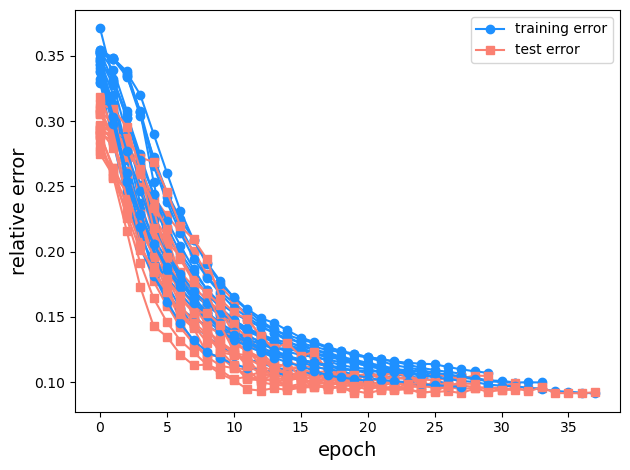

In [16]:
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]
C_das = results_das['C_das'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. If the replica ensemble contains non-converged networks, this will show up as unreasonably large confidence intervals.

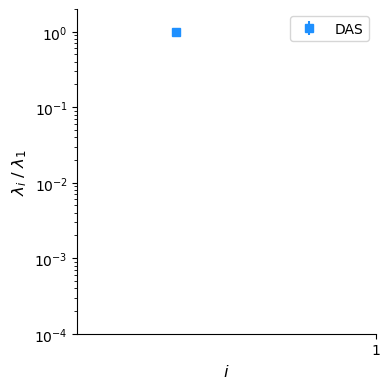

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/epoxy_eigvals_d%d_multiple_qois.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros([n_mc, len(QoIs)])
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

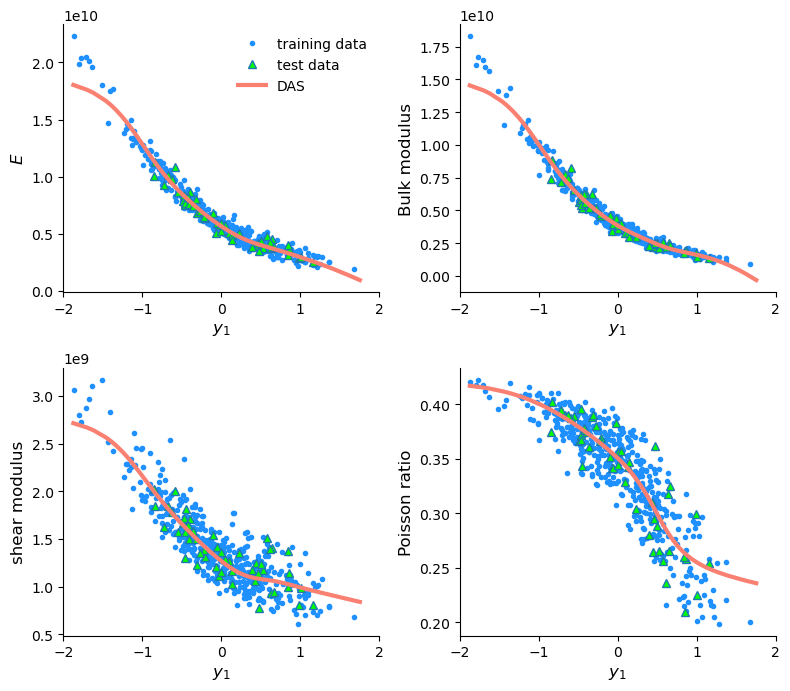

In [21]:
# QoI labels
lbl = {'E11': r'$E$', 'poisson': r'Poisson ratio', 'bulk': 'Bulk modulus', 'shear2': 'shear modulus'}

if d == 1:
    # plot DAS surrogate
    fig = plt.figure(figsize=(8,10))
    spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[1, 1])

    for i in range(len(QoIs)):
        ax = fig.add_subplot(spec[i],  xlim=[-2,2])   
        ax.set_xlabel(r'$y_1$', fontsize=12)
        ax.set_xticks([-2, -1, 0, 1, 2])
        ax.set_ylabel(lbl[QoIs[i]], fontsize=12)
        ax.plot(y_das_train[:, 0], samples_train[:, i], '.', color='dodgerblue', label='training data') 
        ax.plot(y_das_test[:, 0], samples_test[:, i], '^', markerfacecolor='lime', label='test data') 
        ax.plot(y_val_das[idx, 0], das_samples_pred[idx, i], color='salmon', label='DAS', linewidth=3)
        sns.despine(top=True)

        if i == 0: leg = ax.legend(loc=0, frameon=False)

    plt.tight_layout()
    plt.savefig('./images/epoxy_surrogate_d%d_multiple_qoi.png' % (d, ))


### Recreate the global-derivative based sensitivity plots

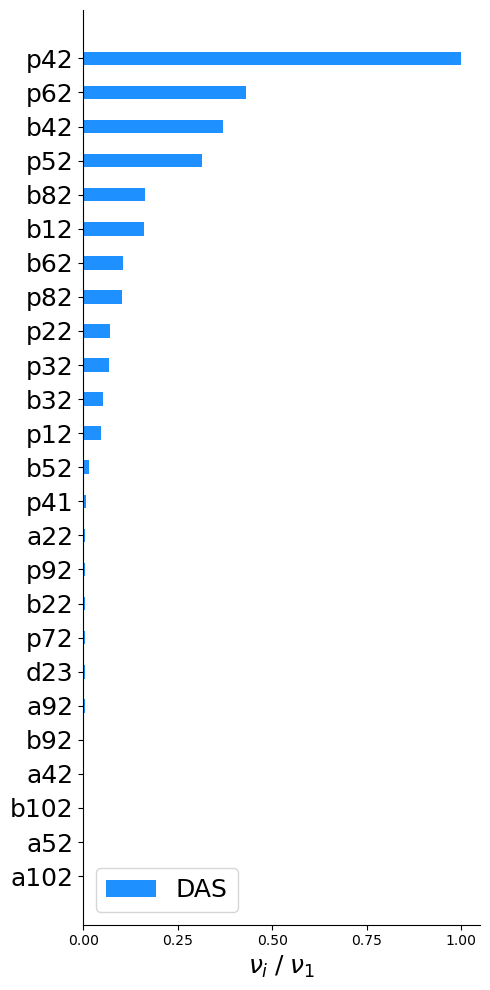

In [22]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names)